In [1]:
import __init__
import numpy as np
from gi import ImgEmulator
from lightprop2d import random_round_hole, cm, um, rectangle_hole, Beam2D, round_hole, gaussian_beam

from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams['figure.dpi'] = 150

### Генерация экспериментальных данных
Данные измерения ширины пучка при дифракции на круглом отверстии в зависимости от расстояния до экрана с отверстием

In [2]:
npoints = 2 ** 9
area_size = 600*um
beam_radius = area_size / 8
wl = 0.632*um  # nm

distances = np.linspace(0, 4, 10)
attempts_num = 50

In [3]:
exp_data = []
for dist in distances:
    exp_data.append([])
    print(f'Processing distanse of {dist} cm')
    for i in range(attempts_num):
        ibeam = Beam2D(area_size, npoints,
                       wl, init_field_gen=round_hole,
                       init_gen_args=(beam_radius * (1 + np.random.uniform(-0.05, 0.05)),), use_gpu=1, unsafe_fft=True)
        ibeam.propagate(dist)
        exp_data[-1].append([dist, ibeam.D4sigma[0].get() / um, ibeam.D4sigma[1].get() / um])

Processing distanse of 0.0 cm
Processing distanse of 0.4444444444444444 cm
Processing distanse of 0.8888888888888888 cm
Processing distanse of 1.3333333333333333 cm
Processing distanse of 1.7777777777777777 cm
Processing distanse of 2.2222222222222223 cm
Processing distanse of 2.6666666666666665 cm
Processing distanse of 3.1111111111111107 cm
Processing distanse of 3.5555555555555554 cm
Processing distanse of 4.0 cm


Фильтрация данных по x и по y

In [4]:
x_exp_data = np.asarray(exp_data)[:, :, 1].T
y_exp_data = np.asarray(exp_data)[:, :, 2].T

График распределения экспериментальных значений в зависимости от расстояния

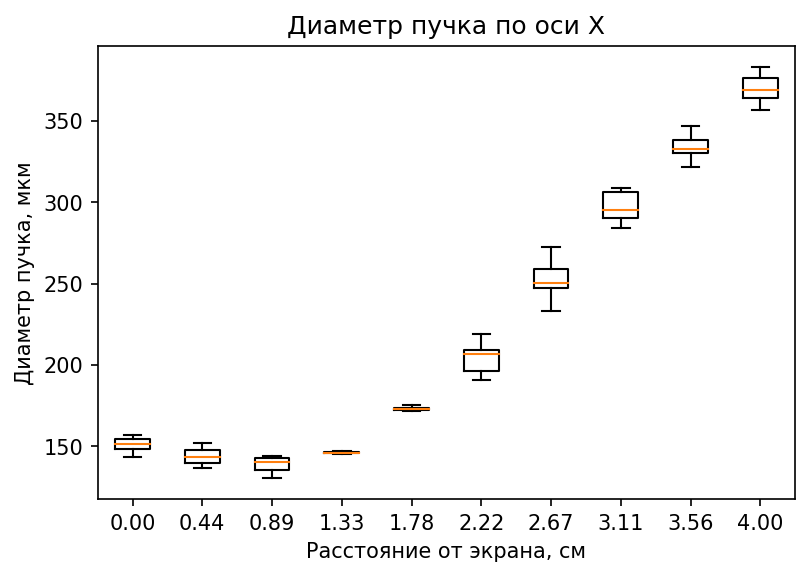

In [5]:
plt.boxplot(x_exp_data, sym='+', labels=[f'{z:.2f}' for z in distances])
plt.xlabel('Расстояние от экрана, см')
plt.ylabel('Диаметр пучка, мкм')
plt.title('Диаметр пучка по оси X')
plt.show()

Загрузка данных в текстовый файл. `reshape` формирует из трехмерного массива двухмерный.

In [6]:
np.savetxt('data.txt', np.array(exp_data).reshape((attempts_num * len(distances), -1)))

### Обработка данных эксперимента по измерению длины волны лазера по дифракции на круглом отверстии
Измерена зависимость диаметра пучка $D$ от расстояния $z$ до круглого отверстия. Известно, что в дальней зоне
$$D(z) = \dfrac{z \lambda}{d},$$
где $\lambda$ -- длина волны лазера, $d$ -- диаметр отверстия. Восстановив наклон графика $D(z)=kz + b$, построенного на основе экспериментальных данных, можно найти длину волны как
$$\lambda=kd$$

Загрузка данных из текстового файла

In [7]:
loaded_data = np.loadtxt('data.txt')

Исключение из `loaded_data` точек, где не выполняется линейная зависимость $D(z)$ (см. график выше), с помощью фильтрации по логическому выражению.

In [8]:
loaded_data = loaded_data[loaded_data[:, 0] >= distances[3]]

In [9]:
loaded_data

array([[  1.33333333, 145.93423939, 145.93423939],
       [  1.33333333, 145.82136836, 145.82136836],
       [  1.33333333, 146.69414384, 146.69414384],
       ...,
       [  4.        , 358.48200418, 358.48200418],
       [  4.        , 369.80708991, 369.80708991],
       [  4.        , 373.63393323, 373.63393323]])

Функции формирования системы для МНК и расчета коэффициентов линейного приближения, а также расчета статистических ошибок из экспериментальных данных.

In [10]:
def construnct_linsys_matrix(exp_data):
    X = loaded_data[:, 0]
    return np.vstack((X, np.ones_like(X))).T

def repeat_std(data, attempts_num):
    std_data = np.std(data, axis=0)
    return np.repeat(std_data, attempts_num)
    
    
def find_std(exp_data, attempts_num):
    std_data = exp_data.copy()
    std_data[:, 1] = repeat_std(
        exp_data[:, 1].reshape(-1, attempts_num).T, attempts_num)
    std_data[:, 2] = repeat_std(
        exp_data[:, 2].reshape(-1, attempts_num).T, attempts_num)
    return std_data


def find_coeffs(exp_data):
    Dx = exp_data[:, 1]
    Dy = exp_data[:, 2]
    A = construnct_linsys_matrix(exp_data)
    kx, bx = np.linalg.lstsq(A, Dx)[0]
    ky, by = np.linalg.lstsq(A, Dy)[0]
    return kx, bx, ky, by


def find_wl(kx, ky, delta_kx, delta_ky, d):
    wl_x = d * kx
    wl_y = d * ky
    dx = d * delta_kx
    dy = d * delta_ky
    return np.mean([wl_x, wl_y]), np.mean([dx, dy])

Нахождение коэффициентов $k, b$ по двум осям и их погрешностей

In [11]:
kx, bx, ky, by = find_coeffs(loaded_data)
delta_data = find_std(loaded_data, attempts_num)
delta_kx, delta_bx, delta_ky, delta_by = np.abs(find_coeffs(delta_data))

C:\Users\VONGOS~1\AppData\Local\Temp/ipykernel_7372/2938913604.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  kx, bx = np.linalg.lstsq(A, Dx)[0]
C:\Users\VONGOS~1\AppData\Local\Temp/ipykernel_7372/2938913604.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ky, by = np.linalg.lstsq(A, Dy)[0]


Нахождение длины волны и её погрешности по коэффициентам $k, b$ по двум осям и их погрешностям

In [12]:
wl_exp, delta_wl = find_wl(kx, ky, delta_kx, delta_ky, beam_radius)

Вывод полученной по МНК линейной аппроксимации данных с 95% доверительным интервалом $\pm3\sigma$

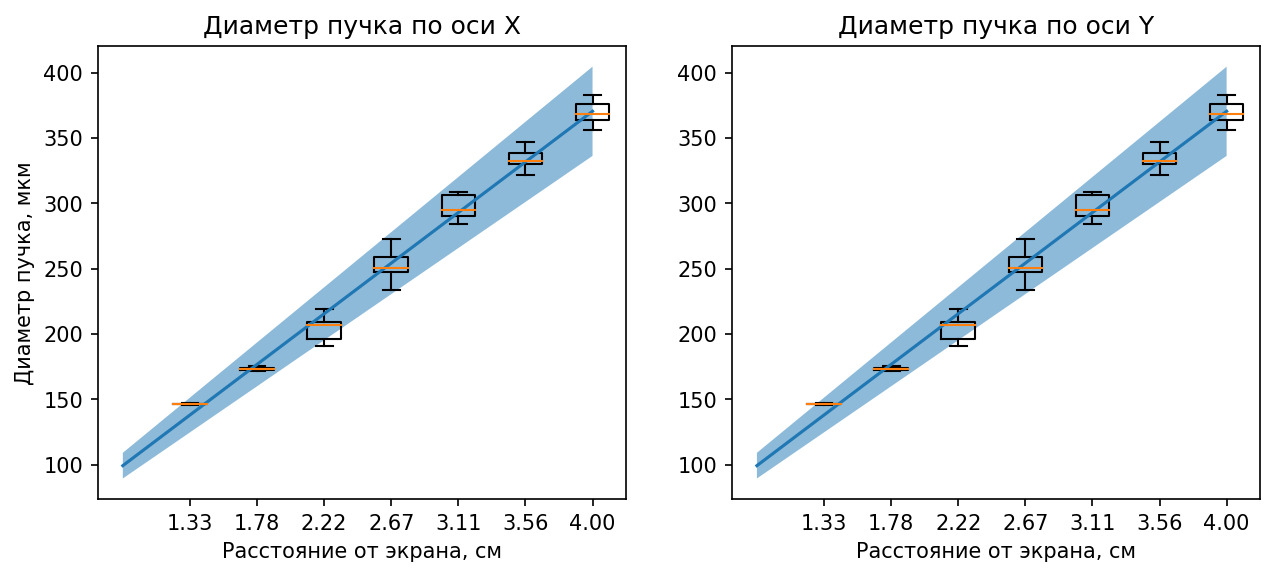

In [13]:
filt_dist = distances[2:]
data1d = lambda axis: loaded_data[:, axis].reshape(-1, attempts_num).T


def confidence_3sigma(k, b, dk, db):
    return (k - 3 * dk) * filt_dist + b - 3 * db, (k + 3 * dk) * filt_dist + b + 3 * db


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].boxplot(data1d(1), labels=[f'{z:.2f}' for z in filt_dist[1:]])
ax[0].plot(kx * filt_dist + bx)
ax[0].fill_between(np.arange(len(filt_dist)), *confidence_3sigma(kx, bx, delta_kx, delta_bx), alpha=0.5)
ax[0].set_ylabel('Диаметр пучка, мкм')
ax[0].set_xlabel('Расстояние от экрана, см')
ax[0].set_title('Диаметр пучка по оси X')

ax[1].boxplot(data1d(2), labels=[f'{z:.2f}' for z in filt_dist[1:]])
ax[1].plot(ky * filt_dist + by)
ax[1].fill_between(np.arange(len(filt_dist)), *confidence_3sigma(ky, by, delta_ky, delta_by), alpha=0.5)
ax[1].set_xlabel('Расстояние от экрана, см')
ax[1].set_title('Диаметр пучка по оси Y')
plt.show()

In [15]:
print(f'Найдена длина волны {wl_exp*1e7:.0f} нм с погрешностью {delta_wl*1e7:.0f} нм')
print(f'Известная длина волны {wl*1e7:.1f} нм')

Найдена длина волны 6539759 нм с погрешностью 195381 нм
Известная длина волны 632.0 нм
